In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
!ls '/gdrive/My Drive/datasets/jena_climate/'

jena_climate_2009_2016.csv


In [5]:
data_dir = '/gdrive/My Drive/datasets/jena_climate/'

In [6]:
import keras
keras.__version__

'2.4.3'

# RNN 성능향상

* 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃
* 순환 층 스태킹 : 네트워크의 표현 능력을 증가(대신 계산 비용이 많이 듭니다).
* 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지

## 기온 예측 문제
독일 예나 시의 막스 플랑크 생물지구화학 연구소( http://www.bgc-jena.mpg.de/wetter/ )의 지상 관측소에서 수집한 날씨데이터

- 2009~2016년 사이의 데이터만 사용
- 기온, 기압, 습도, 풍향 등과 같은 14개의 관측치가 10분마다 기록
- 24시간 이후의 기온을 예측

In [7]:
import os

#data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [8]:
lines[:10]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
 '01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
 '01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 '01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60',
 '01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50',
 '01.01.2009 01:40:00,996.53,-8.43,264.99,-9.3

420,551개 데이터 전체를 넘파이 배열로 변경

In [9]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [10]:
float_data.shape

(420551, 14)

시간에 따른 기온(섭씨) 그래프

In [11]:
from matplotlib import pyplot as plt

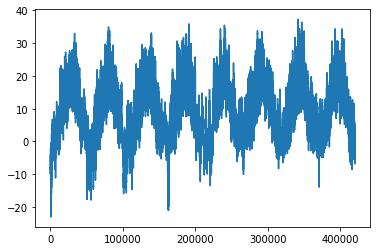

In [12]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

그래프에서 온도에 주기성이 있음

기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프
 - 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 존재

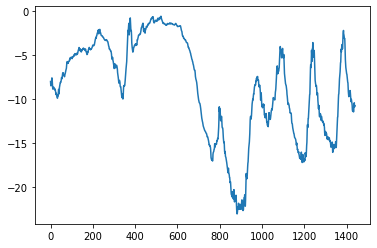

In [12]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Preparing the data

* `lookback = 1440` : 10일 전 데이터로 돌아감
* `steps = 6` : 한 시간마다 데이터 포인트 하나를 샘플링
* `delay = 144` : 24시간이 지난 데이터가 타깃이 됨

시작하기 전에 두 가지 작업

* 각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터 작성

처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산

In [13]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

제너레이터 함수의 매개변수

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [13]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

이제 generator 함수를 사용해 훈련용, 검증용, 테스트용으로 세 개의 제너레이터 작성 

각 제너레이터는 원본 데이터에서 다른 시간대를 사용
- 훈련 제너레이터는 처음 200,000개 타임스텝을 사용
- 검증 제너레이터는 그 다음 100,000개를 사용
- 테스트 제너레이터는 나머지를 사용

In [14]:
lookback = 1440  #10일
step = 6         #1시간
delay = 144      #1일
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 
             - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) 
              - 300001 - lookback) // batch_size

## 상식 수준의 기준점

- 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것
- 평균 절댓값 오차(MAE)로 평가

```python
np.mean(np.abs(preds - targets))
```

다음은 평가를 위한 반복 루프입니다:

In [15]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

2.564887434980494


In [17]:
0.29 * std[1]

2.5672247338393395

- 출력된 MAE는 0.29. 이 온도 데이터는 평균이 0이고 표준 편차가 1
- 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C. 평균 절댓값 오차가 큼

## 기본적인 머신 러닝 방법


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=
                         (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)








Epoch 1/20





500/500 [==============================] - 20s 40ms/step - loss: 1.6217 - val_loss: 0.6593
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.5600 - val_loss: 0.4018
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3164 - val_loss: 0.3289
Epoch 4/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2744 - val_loss: 0.3330
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2584 - val_loss: 0.3068
Epoch 6/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2482 - val_loss: 0.3034
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2394 - val_loss: 0.3360
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2351 - val_loss: 0.3163
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2292 - val_loss: 0.3057
Epoch 10/20
500/500 [==============================] - 15s 29ms/step -

## Loss

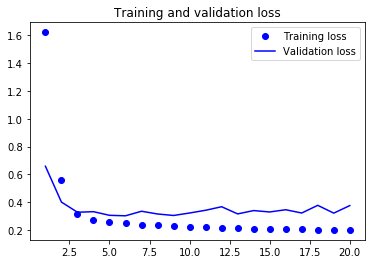

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## GRU

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3074 - val_loss: 0.2729
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2832 - val_loss: 0.2667
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2781 - val_loss: 0.2682
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2716 - val_loss: 0.2667
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2668 - val_loss: 0.2667
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2610 - val_loss: 0.2667
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2571 - val_loss: 0.2737
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2516 - val_loss: 0.2713
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2468 - val_loss: 0.2737
Epoch 

결과 확인

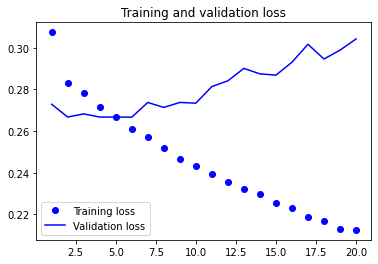

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 시퀀스를 펼쳐서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 더 좋은 성능
- 새로운 검증 MAE는 0.265 이하(크게 과대적합되기 시작하는 곳)이고 정규화되기 전인 섭씨로 복원하면 MAE는 2.35°C. 
- 초기 에러 2.57°C보다는 확실히 낫지만 더 개선의 여지가 있음

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

- dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값
- recurrent_dropout은 순환 상태의 드롭아웃 비율을 정함

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 401s 801ms/step - loss: 0.3272 - val_loss: 0.2810
Epoch 2/40
500/500 [==============================] - 406s 812ms/step - loss: 0.3060 - val_loss: 0.2766
Epoch 3/40
500/500 [==============================] - 401s 803ms/step - loss: 0.3003 - val_loss: 0.2803
Epoch 4/40
500/500 [==============================] - 407s 814ms/step - loss: 0.2958 - val_loss: 0.2850
Epoch 5/40
500/500 [==============================] - 404s 808ms/step - loss: 0.2915 - val_loss: 0.2704
Epoch 6/40
500/500 [==============================] - 406s 812ms/step - loss: 0.2877 - val_loss: 0.2702
Epoch 7/40
500/500 [==============================] - 409s 819ms/step - loss: 0.2854 - val_loss: 0.2711
Epoch 8/40
500/500 [==============================] - 404s 808ms/step - loss: 0.2804 - val_loss: 0.2733
Epoch 9/40
500/500 [==============================] - 405s 810ms/step - loss: 0.2768 - val_loss: 0.2759
Epoch 10/40
500/500 [==============================] - 404s 809m

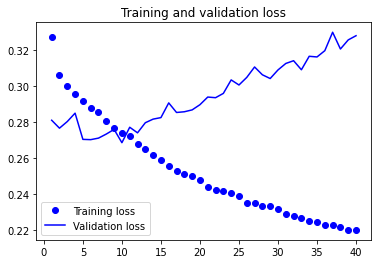

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

30번째 epoch까지 오버피팅이 일어나지 않음. 
평가 점수는 안정적이지만 이전보다 더 나아지지 않음

## 스태킹 순환 층

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. `return_sequences=True`로 지정하면 됩니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 837s 2s/step - loss: 0.3244 - val_loss: 0.2802
Epoch 2/40
500/500 [==============================] - 820s 2s/step - loss: 0.3017 - val_loss: 0.2795
Epoch 3/40
500/500 [==============================] - 830s 2s/step - loss: 0.2947 - val_loss: 0.2701
Epoch 4/40
500/500 [==============================] - 838s 2s/step - loss: 0.2869 - val_loss: 0.2743
Epoch 5/40
500/500 [==============================] - 831s 2s/step - loss: 0.2823 - val_loss: 0.2902
Epoch 6/40
500/500 [==============================] - 853s 2s/step - loss: 0.2764 - val_loss: 0.2681
Epoch 7/40
500/500 [==============================] - 852s 2s/step - loss: 0.2713 - val_loss: 0.2677
Epoch 8/40
500/500 [==============================] - 830s 2s/step - loss: 0.2676 - val_loss: 0.2744
Epoch 9/40
500/500 [==============================] - 848s 2s/step - loss: 0.2630 - val_loss: 0.2704
Epoch 10/40
500/500 [==============================] - 848s 2s/step - loss: 0.2585 - val_lo

In [16]:
float_data.shape[-1]

14

## Loss

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상

## 양방향 RNN

입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿈). 

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮음

